# Phase 2 progress

## Data preprocessing

In this part, I change the label into digital number from string and plot a graph via the length of text.

In [1]:
import pandas as pd
import nltk

In [2]:
df = pd.read_csv('data/fake_or_real_news.csv', nrows=10000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 5 columns):
Unnamed: 0       6335 non-null int64
title            6335 non-null object
text             6335 non-null object
label            6335 non-null object
title_vectors    6335 non-null object
dtypes: int64(1), object(4)
memory usage: 247.5+ KB


In [3]:
df.drop('Unnamed: 0', inplace=True, axis=1)
label_trans = lambda i: 0 if i == 'FAKE' else 1
df.label = df.label.apply(label_trans)
df.head()

,title,text,label,title_vectors
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0,[ 1.1533764e-02 4.2144405e-03 1.9692603e-02 ...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0,[ 0.11267698 0.02518966 -0.00212591 0.021095...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1,[ 0.04253004 0.04300297 0.01848392 0.048672...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0,[ 0.10801624 0.11583211 0.02874823 0.061732...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1,[ 1.69016439e-02 7.13498285e-03 -7.81233795e-...


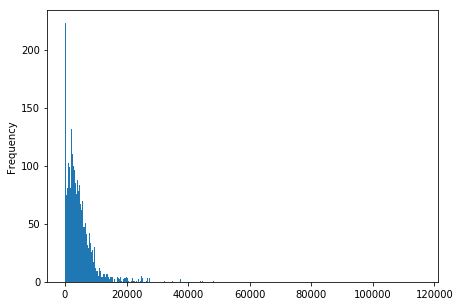

In [4]:
import matplotlib
%matplotlib inline
df['text'].str.len().plot(kind = 'hist', bins = 1000, figsize = (7,5))

## Term document

The contents in text are vary from each other. To normalize them, I transfer all the words into lowercase words and filter all the punctuations. And then tokenize them into a word list.

In [5]:
from string import punctuation
texts = df.text
mapping_table = {ord(char): u' ' for char in punctuation}
tokenized = [nltk.word_tokenize(review.translate(mapping_table)) for review in texts]

In [6]:
def clean_text(tokenized_list):
    import string
    sw = nltk.corpus.stopwords.words('english')
    sw.append("“")
    sw.append("”")
    sw.append("’")
    sw.append("‘")
    sw.append("—")
    new_list = [[token.lower() for token in tlist if token not in string.punctuation and token.lower() not in sw] for tlist in tokenized_list]
    return new_list
cleaned = clean_text(tokenized)

In [7]:
from gensim.models import Doc2Vec, Word2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.corpus import reuters

tokenized_docs = [nltk.word_tokenize(reuters.raw(fileid)) for fileid in reuters.fileids()]
tagged_docs = [TaggedDocument(doc, tags=[idx]) for idx, doc in enumerate(cleaned)]

## Vector transition

I use two ways to transit the words showed up in the word list that I created in last step: Word2Vec and Doc2Vec, and right now I can't tell which one is better.

In [8]:
word_model = Word2Vec(cleaned, size = 300, window = 5, min_count = 1, alpha = 0.025, iter=10, batch_words = 10000)

In [9]:
doc_model = Doc2Vec(size=300, window=5, min_count=5, dm = 1, iter=10)
doc_model.build_vocab(tagged_docs)
doc_model.train(tagged_docs, epochs=10, total_examples=doc_model.corpus_count)

27020435

In [10]:
import numpy as np
doc_vectors = []
for i in range(len(df)):
    doc_vectors.append(doc_model.docvecs[i])
doc_vectors = np.asarray(doc_vectors)
doc_vectors.shape

(6335, 300)

In [11]:
word_vectors = np.zeros((len(df), 300))
for i in range(0, len(df)):
    word_vectors[i] = 0
    for word in cleaned[i]:
        word_vectors[i] += word_model[word]
    if len(cleaned[i]) != 0:
        word_vectors[i] = word_vectors[i] / len(cleaned[i])
word_vectors.shape

/Users/lifesaver/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(6335, 300)

## Set splitting

As learned in first lecture, I split the set into testing set and training set, with 300 features selected, and the test size is set to one third. 

In [24]:
x0 = word_vectors
x = doc_vectors
y = np.array(df['label']) 
from sklearn.model_selection import train_test_split
seed = 2
test_size = 0.33
x0_train, x0_test, y0_train, y0_test = train_test_split(x0, y, test_size=test_size, random_state=seed)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

## Logistic regression

In [13]:
import time
from sklearn.linear_model import LogisticRegression
LR0_model = LogisticRegression()
LR_model = LogisticRegression()
LR0_model = LR0_model.fit(x0_train, y0_train)
LR_model = LR_model.fit(x_train, y_train)
print("Word2Vec + LR:",LR0_model.score(x0_test, y0_test))
print("Doc2Vec  + LR:",LR_model.score(x_test, y_test))

Word2Vec + LR: 0.8976566236250598
Doc2Vec  + LR: 0.8574844571975132


In [14]:
from sklearn.metrics import classification_report
target_names = ['FAKE', 'REAL']
y0_pred = LR0_model.predict(x0_test)
y_pred = LR_model.predict(x_test)
print("Word2Vec + LR")
print(classification_report(y0_test, y0_pred, target_names=target_names))
print("Doc2Vec + LR")
print(classification_report(y_test, y_pred, target_names=target_names))

Word2Vec + LR
             precision    recall  f1-score   support

       FAKE       0.90      0.89      0.90      1050
       REAL       0.89      0.90      0.90      1041

avg / total       0.90      0.90      0.90      2091

Doc2Vec + LR
             precision    recall  f1-score   support

       FAKE       0.83      0.90      0.86      1050
       REAL       0.89      0.81      0.85      1041

avg / total       0.86      0.86      0.86      2091



In [15]:
from sklearn.metrics import * 
LR0_result = [accuracy_score(y0_test, y0_pred), precision_score(y0_test, y0_pred), recall_score(y0_test, y0_pred),
             f1_score(y0_test, y0_pred)]
LR_result = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred),
             f1_score(y_test, y_pred)]

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
RF0_model = RandomForestClassifier(n_estimators = 20, max_features=20, random_state=seed)
RF_model = RandomForestClassifier(n_estimators = 20, max_features=20, random_state=seed)
RF0_model = RF0_model.fit(x0_train, y0_train)
RF_model = RF_model.fit(x_train, y_train)
print("Word2Vec + RF:",RF0_model.score(x0_test, y0_test))
print("Doc2Vec  + RF:",RF_model.score(x_test, y_test))

Word2Vec + RF: 0.8866571018651362
Doc2Vec  + RF: 0.8579626972740315


In [17]:
y0_pred = RF0_model.predict(x0_test)
y_pred = RF_model.predict(x_test)
print("Word2Vec + RF")
print(classification_report(y0_test, y0_pred, target_names=target_names))
print("Doc2Vec + RF")
print(classification_report(y_test, y_pred, target_names=target_names))

Word2Vec + RF
             precision    recall  f1-score   support

       FAKE       0.87      0.91      0.89      1050
       REAL       0.91      0.86      0.88      1041

avg / total       0.89      0.89      0.89      2091

Doc2Vec + RF
             precision    recall  f1-score   support

       FAKE       0.84      0.89      0.86      1050
       REAL       0.88      0.83      0.85      1041

avg / total       0.86      0.86      0.86      2091



In [18]:
from sklearn.metrics import * 
RF0_result = [accuracy_score(y0_test, y0_pred), precision_score(y0_test, y0_pred), recall_score(y0_test, y0_pred),
             f1_score(y0_test, y0_pred)]
RF_result = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred),
             f1_score(y_test, y_pred)]

## XGboost

In [26]:
from xgboost import XGBClassifier
XG0_model = XGBClassifier(max_depth=7, learning_rate=0.2, 
                        n_estimators=20, silent=True, 
                        objective='binary:logistic', nthread=-1, 
                        gamma=0, min_child_weight=1, max_delta_step=0, 
                        subsample=1, colsample_bytree=1, 
                        colsample_bylevel=1, reg_alpha=0, 
                        reg_lambda=1, scale_pos_weight=1, 
                        base_score=0.5, seed=0, missing=None)
XG_model = XGBClassifier(max_depth=7, learning_rate=0.2, 
                        n_estimators=20, silent=True, 
                        objective='binary:logistic', nthread=-1, 
                        gamma=0, min_child_weight=1, max_delta_step=0, 
                        subsample=1, colsample_bytree=1, 
                        colsample_bylevel=1, reg_alpha=0, 
                        reg_lambda=1, scale_pos_weight=1, 
                        base_score=0.5, seed=0, missing=None)
XG0_model = XG0_model.fit(x0_train, y0_train)
XG_model = XG_model.fit(x_train, y_train)
print("Word2Vec + XG:",XG0_model.score(x0_test, y0_test))
print("Doc2Vec  + XG:",XG_model.score(x_test, y_test))

Word2Vec + XG: 0.8871353419416547
Doc2Vec  + XG: 0.8813964610234337


/Users/lifesaver/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/lifesaver/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
y0_pred = XG0_model.predict(x0_test)
y_pred = XG_model.predict(x_test)
print("Word2Vec + XG")
print(classification_report(y0_test, y0_pred, target_names=target_names))
print("Doc2Vec + XG")
print(classification_report(y_test, y_pred, target_names=target_names))

Word2Vec + XG
             precision    recall  f1-score   support

       FAKE       0.88      0.90      0.89      1050
       REAL       0.89      0.88      0.89      1041

avg / total       0.89      0.89      0.89      2091

Doc2Vec + XG
             precision    recall  f1-score   support

       FAKE       0.87      0.89      0.88      1050
       REAL       0.89      0.87      0.88      1041

avg / total       0.88      0.88      0.88      2091



/Users/lifesaver/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/lifesaver/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
from sklearn.metrics import * 
XG0_result = [accuracy_score(y0_test, y0_pred), precision_score(y0_test, y0_pred), recall_score(y0_test, y0_pred),
             f1_score(y0_test, y0_pred)]
XG_result = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred),
             f1_score(y_test, y_pred)]

## Results

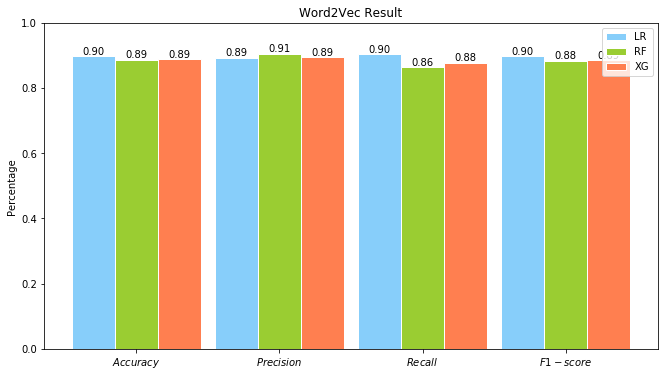

In [29]:
Y1 = np.array(LR0_result[:4])
Y2 = np.array(RF0_result[:4])
Y3 = np.array(XG0_result[:4])
from matplotlib import pyplot as plt
plt.figure(figsize=(11,6))
n = 4
X = np.arange(n)+1
plt.xticks([1.3,2.3,3.3,4.3],[r'$Accuracy$', r'$Precision$', r'$Recall$',r'$F1-score$'])
plt.bar(X,Y1,width = 0.3,facecolor = 'lightskyblue',edgecolor = 'white',label='LR')
plt.bar(X+0.3,Y2,width = 0.3,facecolor = 'yellowgreen',edgecolor = 'white',label='RF')
plt.bar(X+0.6, Y3, width = 0.3,facecolor = 'coral',edgecolor = 'white',label='XG')
for x,y in zip(X,Y1):
    plt.text(x, y, '%.2f' % y, ha='center', va= 'bottom')
for x,y in zip(X,Y2):
    plt.text(x+0.3, y, '%.2f' % y, ha='center', va= 'bottom')
for x,y in zip(X,Y3):
    plt.text(x+0.6, y, '%.2f' % y, ha='center', va= 'bottom')
plt.ylabel('Percentage')
plt.ylim(0,+1)
plt.legend()
plt.title('Word2Vec Result')
plt.show()

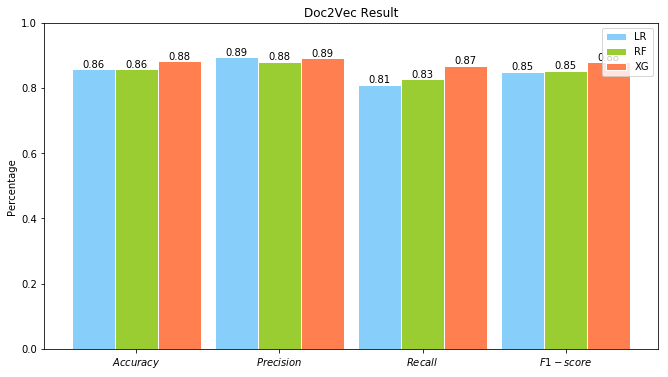

In [30]:
Y1 = np.array(LR_result[:4])
Y2 = np.array(RF_result[:4])
Y3 = np.array(XG_result[:4])
from matplotlib import pyplot as plt
plt.figure(figsize=(11,6))
n = 4
X = np.arange(n)+1
plt.xticks([1.3,2.3,3.3,4.3],[r'$Accuracy$', r'$Precision$', r'$Recall$',r'$F1-score$'])
plt.bar(X,Y1,width = 0.3,facecolor = 'lightskyblue',edgecolor = 'white',label='LR')
plt.bar(X+0.3,Y2,width = 0.3,facecolor = 'yellowgreen',edgecolor = 'white',label='RF')
plt.bar(X+0.6, Y3, width = 0.3,facecolor = 'coral',edgecolor = 'white',label='XG')
for x,y in zip(X,Y1):
    plt.text(x, y, '%.2f' % y, ha='center', va= 'bottom')
for x,y in zip(X,Y2):
    plt.text(x+0.3, y, '%.2f' % y, ha='center', va= 'bottom')
for x,y in zip(X,Y3):
    plt.text(x+0.6, y, '%.2f' % y, ha='center', va= 'bottom')
plt.ylabel('Percentage')
plt.ylim(0,+1)
plt.legend()
plt.title('Doc2Vec Result')
plt.show()

## Analysis

It seems that the Word2Vec has better score in every field comparing to Doc2Vec method, which make sence because when we choose vectors from word it maybe will cause us a lot of time but the result is more accuracy and more specific. The best model in Word2Vec is very hard to say sense the models perform very close to each other, but I will choose logistic regression rather than other two because of time spend. 